In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA version: {torch.version.cuda}") if device.type == 'cuda' else None

Using device: cpu


In [3]:
import sys
sys.path.append("..")  # Add parent directory to path
from python_helpers import get_project_root_dir
from datasets import SoundTracksDataset
import models


In [4]:
full_dataset = SoundTracksDataset()
print(f"Dataset size: {len(full_dataset)} samples")
print(f"Sample features shape: {full_dataset.melspecs[0].shape}")

Dataset size: 192 samples
Sample features shape: torch.Size([128, 323])


In [5]:
train_val, test = full_dataset.train_test_split(split_size=0.2)
train, val = train_val.train_test_split(split_size=0.25)
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 114, Val: 39, Test: 39


In [6]:
MODEL_TYPE = 'resnet'  # Change to 'vgg' or 'nilscnn'
FEATURE_TYPE = 'melspecs'

model = {
    'nilscnn': models.NilsHMeierCNN(FEATURE_TYPE),
    'vgg': models.VGGStyleCNN(FEATURE_TYPE),
    'resnet': models.ResNetStyleCNN(FEATURE_TYPE)
}[MODEL_TYPE].to(device)

print(f"Selected model: {MODEL_TYPE.upper()}")
print(model)


Selected model: RESNET
ResNetStyleCNN(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=

In [7]:
from train import ModelTrainer

trainer = ModelTrainer(
    task='multiclass',
    num_classes=4,
    device=device
)

In [8]:
trainer.train(
    model=model,
    train_dset=train.to(device),
    val_dset=val.to(device),
    batch_size=16,
    max_epochs=100,
    lr=0.0001,
    lambda_val=0.01,
    l1_ratio=0.0,
    take_best=True
)

Training start
Epoch 0    Train Loss=3.7247    Train Acc=0.2544    Val Loss=3.4879    Val Acc=0.3333
Epoch 1    Train Loss=2.7535    Train Acc=0.3158    Val Loss=2.7550    Val Acc=0.2821
Epoch 2    Train Loss=2.7018    Train Acc=0.3947    Val Loss=2.8186    Val Acc=0.3590
Epoch 3    Train Loss=2.4797    Train Acc=0.4825    Val Loss=2.7069    Val Acc=0.3846
Epoch 4    Train Loss=2.4533    Train Acc=0.5877    Val Loss=2.7975    Val Acc=0.4103
Epoch 5    Train Loss=2.1055    Train Acc=0.7982    Val Loss=2.6135    Val Acc=0.5641
Epoch 6    Train Loss=1.6310    Train Acc=0.9561    Val Loss=2.3332    Val Acc=0.6410
Epoch 7    Train Loss=1.5717    Train Acc=0.9825    Val Loss=2.3490    Val Acc=0.6410
Epoch 8    Train Loss=1.5163    Train Acc=0.9912    Val Loss=2.4875    Val Acc=0.6410
Epoch 9    Train Loss=1.5529    Train Acc=0.9912    Val Loss=2.5636    Val Acc=0.5641
Epoch 10    Train Loss=1.5006    Train Acc=0.9912    Val Loss=2.5902    Val Acc=0.5897
Epoch 11    Train Loss=1.5143    Train

In [9]:
test = test.to(device)
test_loss, test_acc, test_cm = trainer.evaluate_performance(model, test)
print(f"\nFinal Test Performance:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2%}")


Final Test Performance:
Loss: 1.3168 | Accuracy: 61.54%


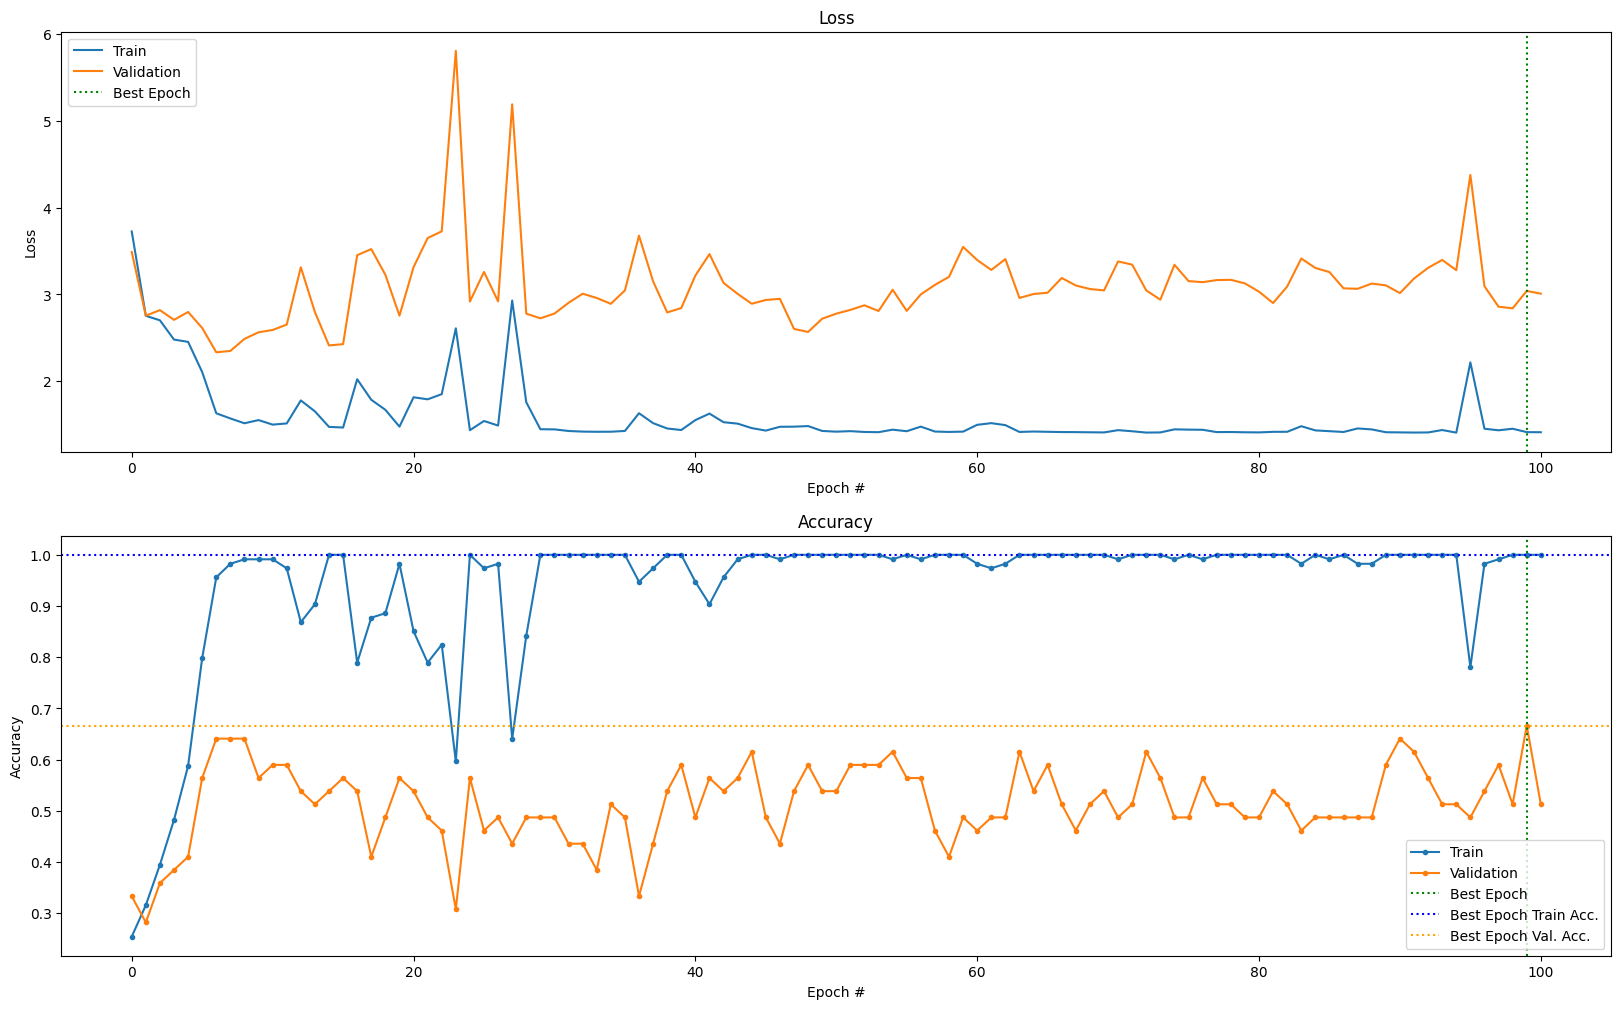

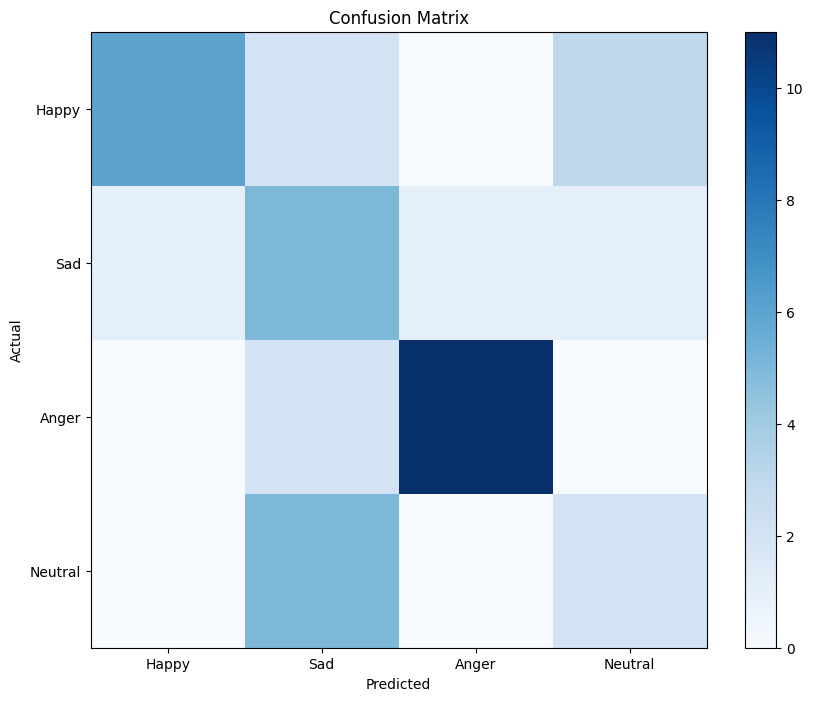

In [10]:
plt.figure(figsize=(10,8))
plt.imshow(test_cm.cpu().numpy(), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.yticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.colorbar()
plt.show()

In [11]:
sample_idx = np.random.choice(len(test), 3)
for idx in sample_idx:
    features, true_label = test[idx]
    with torch.no_grad():
        pred = model({k:v.unsqueeze(0).to(device) for k,v in features.items()})
    
    print(f"\nSample {idx}:")
    print(f"True: {true_label.item()} | Predicted: {pred.argmax().item()}")
    display(Audio(features['waveforms'].cpu().numpy(), rate=44100))


Sample 24:
True: 2 | Predicted: 2



Sample 16:
True: 3 | Predicted: 1



Sample 15:
True: 0 | Predicted: 0
